In [70]:
# import dependencies
# import sys
# !{sys.executable} -m pip install --user install tensorflow==2.8.0. 
import numpy as np
import pandas as pd
import glacierml as gl
import matplotlib.pyplot as plt
RGI = gl.RGI_loader()
df, ref = gl.notebook_data_loader()
pd.set_option('display.max_columns', None)


Global Volume: 101.48, UB: 39.16, LB: 42.34, STD: 42.19


# Plot the glacier volume cumulative distribution function (CDF)

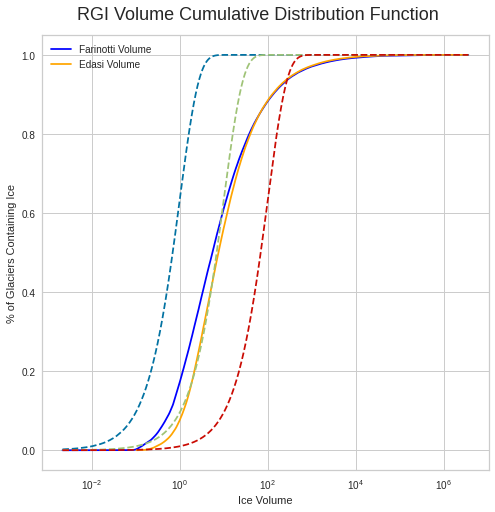

In [25]:
data_1 = ref['Farinotti Mean Thickness'] * ref['Area']
data_2 = df['Edasi Volume'] * 1e3
#sort data


x_1 = np.sort(data_1)
# x = data_1
#calculate CDF values
y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)


x_2 = np.sort(data_2)
# x = data
#calculate CDF values
y_2 = 1. * np.arange(len(data_2)) / (len(data_2) - 1)

#plot CDF
fig, ax = plt.subplots(1,1,figsize=(8, 8))

plt.subplots_adjust(hspace=0.5)

plt.suptitle('RGI Volume Cumulative Distribution Function', fontsize=18, y=0.93)
fig.patch.set_facecolor('w')


plt.subplots_adjust(hspace=0.5)
plt.plot(
    x_1, 
    y_1,
    c = 'blue',
    label = 'Farinotti Volume'
    
)
plt.plot(
    x_2, 
    y_2,
    c = 'orange',
    label = 'Edasi Volume'
)
plt.legend()
ax.set_xscale('log')
ax.set_xlabel('Ice Volume')
ax.set_ylabel('% of Glaciers Containing Ice')

k = 1
for lambd in (1,10,100):
    plt.plot(x_1, 1 - np.exp(- (x_1/lambd)**k ),'--')
# plt.savefig('figs/cdf/cdf.svg')
plt.show()

# Plot probability density function (PDF)

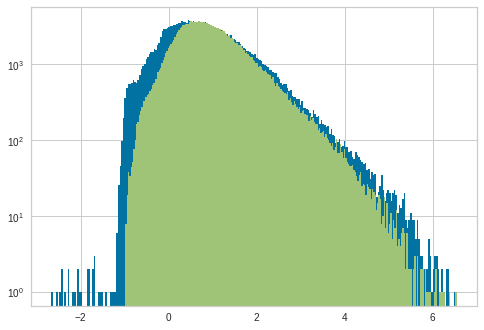

In [3]:
plt.subplots()
plt.hist(np.log10(data_1), 250)
plt.hist(np.log10(data_2), 250)
plt.yscale('log')
# plt.xlim(0,1e5)
plt.show()

# Use the KS test to show that the differences are significantly different 

In [4]:
from scipy.interpolate import interp1d

In [5]:
f1 = interp1d(x_1,y_1)
f2 = interp1d(x_2,y_2)

In [6]:
np.log10(x_2.min())

-0.9795398011626495

In [7]:
x = np.logspace(-0.96, 6, 100)
D = np.max(abs(f2(x) - f1(x)))

# Resample to test difference of sums

We want to address the question, "Is our total ice volumes significantly different from published estimates?"  The following shows that the answer is yes.

Another way to ask the question is, "What is the probability that the published estimate is actually less than our value?"

Let's randomly re-sample 90% of the distributions 1000 times and each time, calculate the sum of the sample.

In [8]:
from tqdm import tqdm
N1 = len(data_1)
assert len(data_1) == len(data_2)
resample_rate = 0.9
Nsample = int(N1 * resample_rate)
X = []
for i in tqdm(range(1000)):
    sum1 = np.sum(data_1.to_numpy()[np.random.choice(N1, size=Nsample, replace=False)])
    sum2 = np.sum(data_2.to_numpy()[np.random.choice(N1, size=Nsample, replace=False)])

    X.append (sum1-sum2)

100%|██████████| 1000/1000 [00:06<00:00, 145.76it/s]


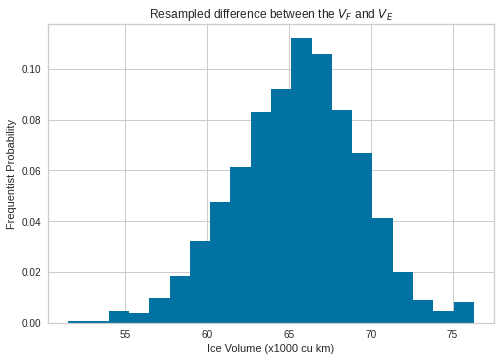

In [9]:
plt.subplots()
plt.hist(np.array(X)/resample_rate/1e6,20,density=True)
plt.title(r'Resampled difference between the $V_F$ and $V_E$')
plt.ylabel('Frequentist Probability')
plt.xlabel('Ice Volume (x1000 cu km)')
plt.show()

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


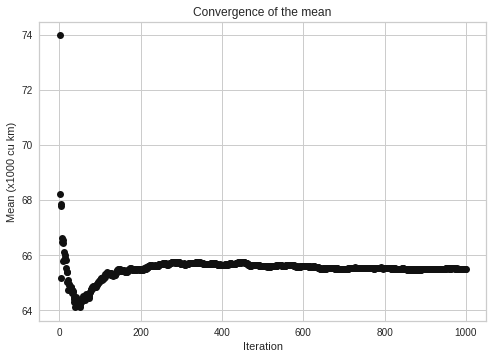

In [10]:
fig,ax=plt.subplots()
for i in range(len(X)):
    ax.plot(i,np.mean(X[0:i])/1e6/resample_rate,'ok')
plt.title('Convergence of the mean')
plt.xlabel('Iteration')
plt.ylabel('Mean (x1000 cu km)')
plt.show()

### The distribution looks approximately normal (ignore the skew for now). So what is the probability that $V_F == V_E$ given the resampled difference mean and standard deviation?

In [11]:
mu  = np.mean(X)/resample_rate/1e6
sig = np.std(X)/resample_rate/1e6
print(f'Mean of Differences = {mu:.2f}')
print(f'Std of Differences = {sig:.2f}')
from scipy.stats import norm
value = 0 # this corresponds to zero difference
probability=norm.pdf(value,loc = mu, scale=sig)
print(f'Probability of equality of volumes = 10**{np.log10(probability):.2f}')

Mean of Differences = 65.51
Std of Differences = 3.83
Probability of equality of volumes = 10**-64.34


### So the probabilty is extremely low that the two estimates are the same!
This is similar to the Z-test with large N.  Let's calculate what the Z-test gave us to see whether the the MC resampling added any value.

In [12]:
mu1 = np.sum(data_1.to_numpy())
mu2 = np.sum(data_2.to_numpy())
std1 = 41
std2 = 42.19
N = len(data_2.to_numpy())
Z = np.abs(mu1-mu2) / np.sqrt(std1**2/N+std2**2/N)
print(f'log10(Z) = {np.log10(Z)}')

print(f'p  = {norm.sf(abs(Z))}')

log10(Z) = 8.714496106883031
p  = 0.0


For such a large p-value, scipy just rounds the probabilty to zero. I think that settles it.  The differences are significant.

# Next level up:  Account for the uncertainty as quantified in the bootstraps

In [13]:
m_F = (ref['Farinotti Mean Thickness'] * ref['Area']).to_numpy()
m_E = (ref['Edasi Mean Thickness'] * ref['Area']).to_numpy()
s_E = (ref['Thickness Std Dev'] * ref['Area']).to_numpy()

N = len(data_1)

resample_rate = 0.9
Nsample = int(N1 * resample_rate)
X = []
vector_normal_rand = np.vectorize(norm.rvs)
for i in tqdm(range(1000)):
    
    # First, draw from the Bootstrap EDF
    edasi_sample=vector_normal_rand(m_E,s_E)
#     edasi_sample = np.zeros_like(m_E)
#     for i in range(len(edasi_sample)):
#         edasi_sample[i] = norm.rvs(loc=m_E[i], scale=s_E[i], size=1)
    
    mc_resample_F = m_F[np.random.choice(N, size=Nsample, replace=False)]
    mc_resample_E = m_E[np.random.choice(N, size=Nsample, replace=False)]
    
    sum_F = np.sum(mc_resample_F)
    sum_E = np.sum(mc_resample_E)

    X.append (sum_F-sum_E)

100%|██████████| 1000/1000 [1:11:49<00:00,  4.31s/it]


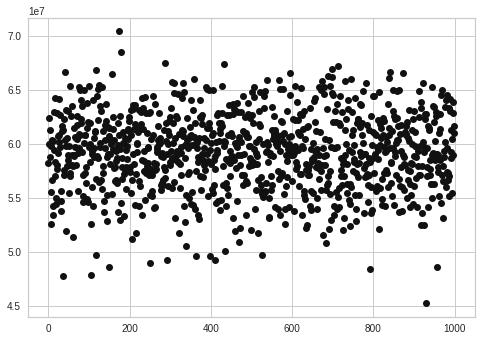

In [14]:
plt.plot(X,'ok')
plt.show()

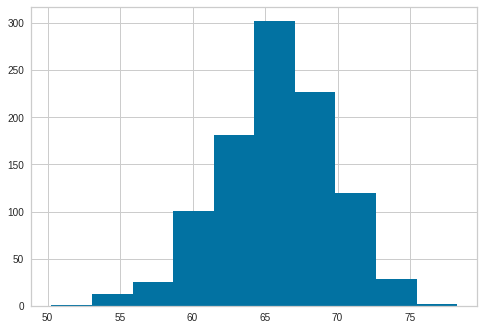

In [15]:
plt.hist(np.array(X)/1e6 / resample_rate)
plt.show()

In [16]:
mu  = np.mean(X)/resample_rate/1e6
sig = np.std(X)/resample_rate/1e6
print(f'Mean of Differences = {mu:.2f}')
print(f'Std of Differences = {sig:.2f}')

Mean of Differences = 65.76
Std of Differences = 3.94
